In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np;
from gpytorch.kernels import Kernel
import scipy.io
import warnings
warnings.filterwarnings('ignore')
from scipy.linalg import expm


In [2]:
from pssgp.kernels import RBF
from pssgp.model import StateSpaceGP
import tensorflow as tf

In [3]:
import yaml

In [4]:
# GP Model Kernel is a parameter.
class GPModel(gpytorch.models.ExactGP):
    def __init__(self,train_x, train_y, likelihood, kernel):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel; ##Kernel function

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
       # print(np.linalg.eig(covar_x.numpy()))
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [5]:
##Set up Kernels as list
PerKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
PerKernel.period = 2*math.pi ##standard period 
RBFKernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
RQKernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
RQKernel.base_kernel.alpha.data = 20*torch.tensor(1)
ListofKernel = [RBFKernel, RBFKernel,
                PerKernel,  RQKernel];
KernelStr = ["RBF", "OU", "PER" , "RQ"];

# Question 1 Priors

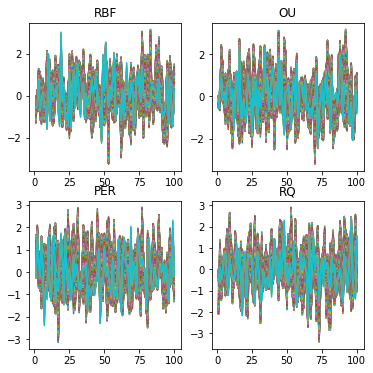

In [6]:
f, ax = plt.subplots(2, 2, figsize=(6, 6))
for i in range(4):
    Currkernel = ListofKernel[0];
    Currkernel.outputscale = 1;
    Currkernel.base_kernel.lengthscale = 20;
    # Training data is 100 points in [0,1] inclusive regularly spaced
    test_data = torch.arange(1, 101, dtype=torch.float32)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model  =  GPModel(test_data , None , likelihood, Currkernel)
    f_pred =  model(test_data)
    f_samples = f_pred.rsample(sample_shape = torch.Size([100]))
    ax[int(i/2),i%2].plot(test_data, f_samples.detach())
    ax[int(i/2),i%2].set_title(KernelStr[i])

Note, We did not include ARD above to save space because for one dimensions is the same as RBF. We see that the a^2 parameter determines the range of our prior or the difference between the min and max value. A larger a means a larger range. 

The lengthscale or l parameter determines how greedy your algorithm turns out, or how many sharp modes your alogrithm will have. smaller means many modes. Bigger means few modes

Alpha determines the weighting of large vs small scale variations. Mathmatically, we can see based on the definition of exponential and infinite alpha gives you the RBF kernel

# Question 2 Posterior Samp.

In [7]:
##Function that plots the kernel confidence region + sample functions
def plotFpred(f_preds, xtrain,ytrain,xtest,meanY, std, KernelStr):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 2, figsize=(9, 4))
        # Get upper and lower confidence bounds
        lower, upper = f_preds.confidence_region()
        lower = lower*std +meanY
        upper = upper*std +meanY
        ytrain = ytrain*std + meanY
        # Plot training data as black stars
        ax[0].plot(xtrain, ytrain, 'k*')
        # Plot predictive means as blue line
        ax[0].plot(test_x, f_preds.mean*std+meanY, 'b')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(test_x.numpy(), lower.numpy(),
                           upper.numpy(), alpha=0.5)
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
        ax[0].set_title(KernelStr + 'Confidence')
        ax[1].plot(xtrain, ytrain, 'k*')
        # Plot predictive means as blue line
        f_samples = f_preds.rsample(sample_shape = torch.Size([2]))
        for samples in f_samples.detach():
            ax[1].plot(test_x, samples*std+meanY)
        ax[1].set_title(KernelStr + 'Sample Functions')

In [8]:
##Data processing
D = scipy.io.loadmat("airline.mat")
#xtrain = D['drag_x_train']
#y = D["vx_train"]
xtrain = D["xtrain"]
y = D["ytrain"]
meanY = np.array(y).sum()/len(y);
std = np.array(y).std();
ytrain = (y-meanY)/std #Divide by standard deviation
data = (xtrain.astype(float),ytrain.astype(float))
xtrain = torch.tensor(xtrain).float().flatten()
ytrain = torch.tensor(ytrain).float().flatten()
test_x = D["xtest"]
test_x= xtrain.clone()-0.1
#test_x = D["xstar"]
#test_x = torch.tensor(test_x).float().flatten()

In [9]:
noise_variance = 1.
lengthscale = 4.5572
variance = 2.6980276107788086

order = 6  # Order of the RBF approximation for (P)SSGP, will not be used if the GP model is GPR
balancing_iter = 5  # Number of balancing steps for the resulting SDE to make it more stable, will not be used if the GP model is GPR
cov = RBF(variance=variance, lengthscales=lengthscale, order=order, balancing_iter=balancing_iter)

ssgp = StateSpaceGP(data=data, kernel=cov, noise_variance=noise_variance, parallel=False)

pssgp = StateSpaceGP(data=data, kernel=cov, noise_variance=noise_variance, parallel=True, max_parallel=1000)  
# max_parallel should be bigger than n_training + n_pred

for model in [ssgp, pssgp]:
    print(model.maximum_log_likelihood_objective())

Instructions for updating:
Do not call `graph_parents`.
tf.Tensor(-116.89438010112067, shape=(), dtype=float64)
tf.Tensor(-116.89438010112066, shape=(), dtype=float64)


In [10]:
print(ssgp._make_model(data[0])[2][0])

tf.Tensor(
[[ 4.95212347e-08  1.31626644e-06  1.30429313e-05  5.05119449e-05
   5.54220516e-05 -2.64991054e-05]
 [ 1.31626644e-06  3.54690461e-05  3.57938320e-04  1.42405968e-03
   1.65324017e-03 -6.96573158e-04]
 [ 1.30429313e-05  3.57938320e-04  3.70343116e-03  1.53044232e-02
   1.92634909e-02 -6.45452478e-03]
 [ 5.05119449e-05  1.42405968e-03  1.53044232e-02  6.71463931e-02
   9.61492032e-02 -1.75736103e-02]
 [ 5.54220516e-05  1.65324017e-03  1.92634909e-02  9.61492032e-02
   1.79774918e-01  3.47720960e-02]
 [-2.64991054e-05 -6.96573158e-04 -6.45452478e-03 -1.75736103e-02
   3.47720960e-02  1.87777150e-01]], shape=(6, 6), dtype=float64)


In [11]:
print(cov.get_sde())

ContinuousDiscreteModel(P0=<tf.Tensor: shape=(6, 6), dtype=float64, numpy=
array([[ 2.70610563e+00,  3.11766528e-16, -1.76014851e+00,
         6.67195389e-17,  3.37598170e-01, -4.46338253e-19],
       [ 3.11766528e-16,  3.65169638e+00, -1.11828326e-16,
        -2.07792950e+00,  8.88534962e-17,  2.66753444e-01],
       [-1.76014851e+00, -1.11828326e-16,  3.65515174e+00,
        -0.00000000e+00, -1.33414936e+00,  7.43964681e-17],
       [ 6.67195389e-17, -2.07792950e+00, -0.00000000e+00,
         2.25016947e+00, -0.00000000e+00, -5.36557514e-01],
       [ 3.37598170e-01,  8.88534962e-17, -1.33414936e+00,
        -0.00000000e+00,  9.04534889e-01, -0.00000000e+00],
       [-4.46338253e-19,  2.66753444e-01,  7.43964681e-17,
        -5.36557514e-01, -0.00000000e+00,  3.75522130e-01]])>, F=<tf.Tensor: shape=(6, 6), dtype=float64, numpy=
array([[ 0.        ,  0.19144297,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.39717762,  0.        ,  0.

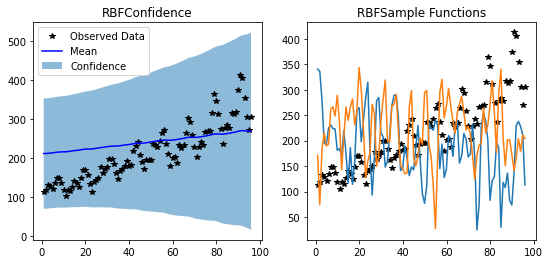

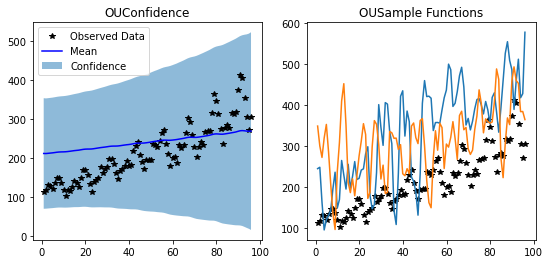

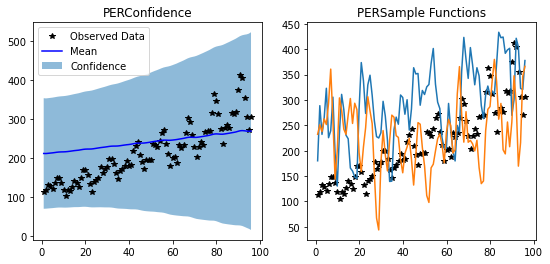

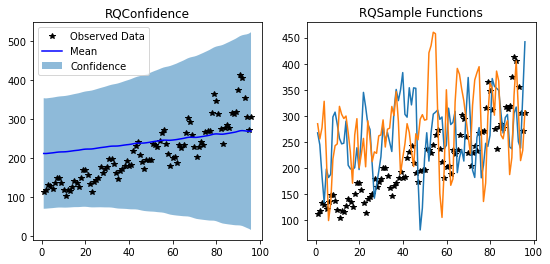

In [12]:
for i in range(4):
    Currkernel = ListofKernel[0]
    Currkernel.outputscale = 1;
    Currkernel.base_kernel.lengthscale = 1;
    Currkernel = Currkernel + gpytorch.kernels.LinearKernel()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = std # CovarNoise rescaled by std
    model  =  GPModel(xtrain , ytrain , likelihood, Currkernel)
    model.eval()
    f_pred = model(test_x)
    plotFpred(f_pred, xtrain,ytrain,test_x,meanY, std, KernelStr[i])

1.1669139862060547


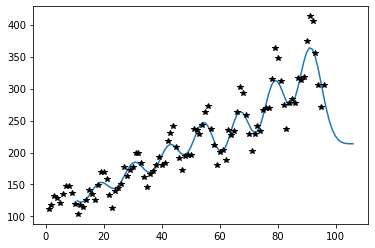

In [13]:
import time

start = time.time()
output, var = ssgp.predict_f(test_x+10)
end = time.time()
print(end - start)
output = output*std+meanY
plt.plot(test_x+10,output)
plt.plot(xtrain, ytrain*std+meanY, 'k*')

In [14]:
ssgp._make_model(data[0])[2]


<tf.Tensor: shape=(96, 6, 6), dtype=float64, numpy=
array([[[ 4.95212347e-08,  1.31626644e-06,  1.30429313e-05,
          5.05119449e-05,  5.54220516e-05, -2.64991054e-05],
        [ 1.31626644e-06,  3.54690461e-05,  3.57938320e-04,
          1.42405968e-03,  1.65324017e-03, -6.96573158e-04],
        [ 1.30429313e-05,  3.57938320e-04,  3.70343116e-03,
          1.53044232e-02,  1.92634909e-02, -6.45452478e-03],
        [ 5.05119449e-05,  1.42405968e-03,  1.53044232e-02,
          6.71463931e-02,  9.61492032e-02, -1.75736103e-02],
        [ 5.54220516e-05,  1.65324017e-03,  1.92634909e-02,
          9.61492032e-02,  1.79774918e-01,  3.47720960e-02],
        [-2.64991054e-05, -6.96573158e-04, -6.45452478e-03,
         -1.75736103e-02,  3.47720960e-02,  1.87777150e-01]],

       [[ 4.95212347e-08,  1.31626644e-06,  1.30429313e-05,
          5.05119449e-05,  5.54220516e-05, -2.64991054e-05],
        [ 1.31626644e-06,  3.54690461e-05,  3.57938320e-04,
          1.42405968e-03,  1.65324017e-

In [15]:
discrete_model = cov.get_sde()
P_inf = discrete_model[0].numpy();
F = discrete_model[1].numpy();
L = discrete_model[2].numpy();
H = discrete_model[3].numpy();
Q = discrete_model[4].numpy(); 

In [16]:
print(tf.reduce_sum(model[1][3]-expm(F)))


TypeError: 'GPModel' object is not subscriptable

In [ ]:
class KalmanFilter:
    def __init__(self,A,B,C,Q,R):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
    def predict(self,xt,covar,dt):
        #xt_1 = np.matmul(self.A,xt)*dt+xt
        A_now = expm(self.A*dt)
        xt_1 = np.matmul(A_now,xt)
        #diff = xt_1- np.matmul(self.A,xt)*dt-xt
        covar_t1 = np.matmul(np.matmul(A_now,covar),A_now.T)+self.Q
        return xt_1,covar_t1
    def update(self,zt,xt,covar):
        Kt = np.matmul(np.matmul(self.C,covar),self.C.T)+self.R
        Kt = np.matmul(covar,self.C.T)/Kt
        covar_t1 = covar - np.matmul(Kt,np.matmul(self.C,covar))
        xt_1 = xt+Kt*(zt-np.matmul(self.C,xt))
        return xt_1,covar_t1
        

In [ ]:
model = KalmanFilter(F,L,H,Q,variance)
xtrain_kal = xtrain.numpy()
xt = np.zeros((6,1))
xt[0,0] =  ytrain[0]
covar = P_inf;
y_predict = np.zeros(96)
x_interpol = np.zeros(950)
y_interpol = np.zeros(950)

y_predict[0] = xt[0]
t=0.0
count =0
for i in range(1,96):
    dt = xtrain_kal[i]-xtrain_kal[i-1]
    t+=dt
    xt_p,covar_p = model.predict(xt,covar,dt)
    y_predict[i] = xt_p[0]
    for j in range(5):
        x_interpol[count]=t+dt*j/5
        xt_p,covar_p = model.predict(xt,covar,dt*j/5)
        y_interpol[count] = xt_p[0]
        count = count +1
    xt,covar = model.update(ytrain[i].numpy(),xt_p,covar_p)

plt.plot(xtrain,y_predict*std+meanY)
plt.plot(xtrain, ytrain*std+meanY, 'k*')
plt.plot(x_interpol[:count], y_interpol[:count]*std+meanY)

In [ ]:
plt.plot(xtrain,y_predict*std+meanY)
plt.plot(xtrain, ytrain*std+meanY, 'k*')
t_test = 0.8*96
i=0
t=xtrain_kal[i];
t=0.0
extraSamples = 10;
x_dropoff = np.zeros(extraSamples*2);
y_dropoff = np.zeros(extraSamples*2);
while xtrain_kal[i] < t_test:
    dt = xtrain_kal[i+1]- xtrain_kal[i]
    t+=dt
    xt_p,covar_p = model.predict(xt,covar,dt)
    xt,covar = model.update(ytrain[i].numpy(),xt_p,covar_p)
    i+=1
xt_p=xt
covar_p = covar;
plt.plot(t_test,xt[0]*std+meanY,'ro')
dt = 0.5
t_lead = t
for i in range(extraSamples):
    x_dropoff[extraSamples-i-1]=t_lead
    xt_p,covar_p = model.predict(xt_p,covar_p,-1*dt)
    #print(xt_p)
    y_dropoff[extraSamples-i-1]=xt_p[0]
    t_lead-=dt;
xt_p=xt
covar_p = covar;
t_lead = t
for i in range(extraSamples):
    x_dropoff[i+extraSamples]=t_lead
    xt_p,covar_p = model.predict(xt_p,covar_p,dt)
    #print(xt_p)
    y_dropoff[i+extraSamples]=xt_p[0]
    t_lead+=dt;
plt.plot(x_dropoff,y_dropoff*std+meanY)
plt.figure();


# Learning the Kernel Hyper  

In [ ]:
def train(model, likelihood, train_x, train_y):# Find optimal model hyperparameters
    model.train()
    likelihood.train()
    training_iter =100;
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
def test(model, likelihood, test_x):
    model.eval() ##Test takes model returns output
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        f_preds = likelihood(model(test_x)) 
    return f_preds

def train_plot(Currkernel,xtrain,ytrain,xtest,meanY, 
               std,noise, KernelStr, ytest=None):
    likelihood = gpytorch.likelihoods.GaussianLikelihood() ##One function to call both train and plot
    likelihood.noise_covar.noise =noise # CovarNoise rescaled by std
    model  =  GPModel(xtrain , ytrain , likelihood, Currkernel)
    train(model, likelihood, xtrain, ytrain)
    start = time.time()
    f_preds= test(model, likelihood, xtest)
    end = time.time()
    print(end - start)
    if ytest is None: ##Switch for part 4 function plotting
        plotFpred(f_preds, xtrain,ytrain,xtest,meanY, std, KernelStr)
    else:
        plotFpred(f_preds, xtest,ytest,xtest,meanY, std, KernelStr)

# Part 3A

In [ ]:
for i in range(4):
    Currkernel = gpytorch.kernels.RBFKernel()
    #Currkernel.outputscale = 1;
    Currkernel.lengthscale = 5;
    plt.figure()
    train_plot(Currkernel,xtrain,ytrain,test_x,meanY,std,std*0.01, KernelStr[i])

In [ ]:
print(Currkernel.lengthscale)
print(std*0.1)

We see that for every case, except the Periodic Kernel, our curves fit much better after our hyperparameters are tuned properly with the EMLL. The periodic Kernel failure to fit is most likely because it doesn't seem to represent the polynomial well as the X^4 is the dominant term. As a result, even with good hyperparameters if the function is outside of the kernel support it doesn't matter it will be a bad fit. 

# Part 3B 

In [ ]:
def plot3D(model, likelihood,xtrain,ytrain,std,meanY,title):
    zaxisU = np.zeros((40,40))
    zaxisL = np.zeros((40,40))
    xaxis= np.arange(-5, 5, 0.25)
    yaxis = np.arange(-5, 5, 0.25)
    xaxis, yaxis = np.meshgrid(xaxis, yaxis)
    ytrain = ytrain*std+meanY
    for i in range(40):    
        xtest = np.zeros((40,2))
        ycon = yaxis[i,0]
        xtest[:,1] = ycon*np.ones(40); ##Calculate the 3D Mesh by y row y constant
        xtest[:,0] = xaxis[i,:] ## X variable
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            xtest = torch.tensor(xtest).float()
            f_preds= test(model, likelihood, xtest)
            lower, upper = f_preds.confidence_region()
            zaxisU[i,:] = upper*std+meanY ##Upper bound of our guess
            zaxisL[i,:] = lower*std+meanY ##Lowe bound of our guess
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    print(ytrain.shape)
    ax.scatter(xtrain[:,0], xtrain[:,1], ytrain, c='#2ca02c')
    surf = ax.plot_surface(xaxis, yaxis, zaxisU, #Plot upper
                            linewidth=0, antialiased=False)
    surf = ax.plot_surface(xaxis, yaxis, zaxisL, #Plot lower
                            linewidth=0, antialiased=False)
    ax.set_title(title)

In [ ]:
D2_data = scipy.io.loadmat("2dfunc.mat")
xtrain = D2_data['x']
ytrain = D2_data['y']
meanY = np.array(ytrain).sum()/len(ytrain);
std = np.array(ytrain).std();
ytrain = (ytrain-meanY)/std #Divide by standard deviation
xtrain = torch.tensor(xtrain).float()
ytrain = torch.tensor(ytrain).float().flatten()


In [ ]:
RBFKernel = ListofKernel[0] #RBF Kernel
RBFKernel.outputscale = 1;
RBFKernel.base_kernel.lengthscale = 5;
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise =10 # CovarNoise rescaled by std
model  =  GPModel(xtrain , ytrain , likelihood, Currkernel) 
train(model, likelihood, xtrain, ytrain)
plot3D(model, likelihood,xtrain,ytrain,std,meanY,"RBF KERNEL")
ARDKernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
model  =  GPModel(xtrain , ytrain , likelihood, ARDKernel)
train(model, likelihood, xtrain, ytrain)
plot3D(model, likelihood,xtrain,ytrain,std,meanY,"ARD KERNEL")

Here we plot the upper and lower confidence regions with both ARD and RBF. I noticied if you look at the valley between -2,-2. The ARD fitting has lower variance in the training region than the RBF. Also, the ARD in high noise situations can capture better some of the curves or motions than the RBF for example if I set covar noise = 20 the RBF will give a flat surface while the ARD will still have some bend. 

# Question 4

In [ ]:
airlineData = scipy.io.loadmat("airline.mat") ##Preprocess data removing STd and mean
xtrain = airlineData['xtrain']
ytrain = airlineData['ytrain']
meanY = np.array(y).sum()/len(ytrain);
std = np.array(ytrain).std();
ytrain = (ytrain-meanY)/std #Divide by standard deviation
xtrain = torch.tensor(xtrain).float().flatten()
ytrain = torch.tensor(ytrain).float().flatten()
test_x = airlineData["xtest"]
test_y = airlineData["ytest"]
test_y = (test_y-meanY)/std ##For plotting function to work nicely
test_y = torch.tensor(test_y).float().flatten()
test_x = torch.tensor(test_x).float().flatten()
test_x = torch.cat([xtrain,test_x],dim=0);
test_y = torch.cat([ytrain,test_y],dim=0);
##Function looks like a sine wave + a polynomial 
PerKernel =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
PerKernel.outputscale = 0.2; ##The sine wave is less important than the poly
PerKernel.base_kernel.lengthscale = 5;
PerKernel.period = 2*math.pi ## Set it so the periodic Kernel has the same period
RBFKernel = gpytorch.kernels.RBFKernel() 
RBFKernel.lengthscale = 5;
CombKernel = gpytorch.kernels.ScaleKernel(PerKernel + RBFKernel);
CombKernel.outputscale = 1
##Make a guess on the noise level
train_plot(CombKernel,xtrain,ytrain,test_x,meanY, std, 1, "Comb Per+RBF", test_y)

I initially expected a RBF + 0.2 Periodic Kernel to do very well. This is because initially, the object mirrors a linear line + a sine wave that is slihgtly smaller like 20%. As a a result, I hope the combined version would greatly improve on both version. This works very well for the training example range. This function generalizes very poorly past the initial training example range though as based on the RBF kernel the further we are from training examples our mean collapses to the base mean, and our covariance explodes. 